+ Requirements:
    1. The estimated time to carry out this activity is approximately half an hour.
<br><br>
+ Objectives of this notebook:
    1. Presentation of the distortion model.
    2. Presentation of the camera model.
<br><br>
+ Summary of activities:
    1. Direct projection code implemented in Python with Numpy will be analyzed.

%%latex
\tableofcontents

# Introduction
The camera model is a transformation matrix $^{nd}\mathbf{T}_w$ that allows projecting a 3D point of the world $\mathbf{p}_w$ obtaining the pixel $\mathbf{p}_{nd} $ on the 2D image plane.

$$\begin{equation*} \mathbf{p}_{nd} = \, ^{nd}\mathbf{T}_w \cdot \mathbf{p}_w \end{equation*}$$

The camera model will obtain the coordinates of the pixel $\mathbf{p}_{nd}$ without considering the possible radial or tangential distortions produced by the camera optics.

# Radial distortion model
The optics are designed to present negligible distortions $(\mathbf{p}_{nd} \approx \mathbf{p}_{d})$. In the case that the camera optics produce considerable distortions, mathematical models are used to correct them. The most frequent distortion is radial, which occurs with small focal length optics (wide angular). This type of distortion can be corrected with the following mathematical model:

| Distorted pixel | Radial correction model | Undistorted pixel |
| --- | --- | --- |
| $$\begin{equation*} \mathbf{p}_d = \begin{bmatrix} {x}_d \\ {y}_d \end{bmatrix} + \mathbf{c} \:\:\:\:\:\: \end{equation*}$$ | $$\begin{equation*} {r}_d^2 = {x}_d^2 + {y}_d^2 \\ D = {r}_d \cdot (k_1{r}_d^2 + k_2{r}_d^4) \\ {r}_{nd} = {r}_d + D \end{equation*}$$ | $$\begin{equation*} \mathbf{p}_{nd} = \begin{bmatrix} {x}_d \\ {y}_d \end{bmatrix} \cdot \frac{{r}_{nd}}{{r}_d} + \mathbf{c} \:\:\:\:\:\:\:\:\:\: \end{equation*}$$ |
 

<img src="imgs/distorsiones_radiales.JPG" alt="Drawing" style="margin: auto;width: 300px;"/>

Although there are other models with more radial and tangential distortion parameters, this two-parameter model $(k_1, k_2)$ of radial distortion practically corrects distortion problems in most applications.

In [2]:
import numpy as np
import cv2
import os
from PIL import Image
from torchvision.transforms import transforms
from math import pi
import math
import random
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output, Image, display, HTML  # funcionalidad para mostrar imágenes en el cuaderno

In [3]:
class Cam1:
    
    # Parameters of the radial distortion model
    # Barrel distortion
    #k1 = 0.0000000000006
    #k2 = 0.0000000000006
    
    # Pincushion distortion
    k1 = -0.00000007
    k2 = -0.00000000000009
    
    """ Principal point """
    cx = 700  # cx = uo = xo
    cy = 500  # cy = vo = yo
    
    #def __init__
    
    def undistort(self, pd):
        xd, yd = pd[0]-self.cx, pd[1]-self.cy
        
        rd2 = (xd**2+yd**2)
        rd = math.sqrt(rd2)
        D = rd*(self.k1*rd2+self.k2*rd2*rd2)
        rnd = rd + D
        pnd =  np.asarray([xd, yd]) * rnd/rd
        
        return [pnd[0]+self.cx, pnd[1]+self.cy]


    def distort(self, pnd):
        xnd, ynd = pnd[0]-self.cx, pnd[1]-self.cy
        
        rnd2 = (xnd**2+ynd**2)
        rnd = math.sqrt(rnd2)
        # k2*rd5 + k1*rd3 + rd - rnd = 0
        coeff = [self.k2, 0, self.k1, 0, 1.0, -rnd]
        rd = np.roots(coeff)
        rd = rd[np.isreal(rd)][-1].real
        pd =  np.asarray([xnd, ynd]) * rd/rnd
        
        return [pd[0]+self.cx, pd[1]+self.cy]

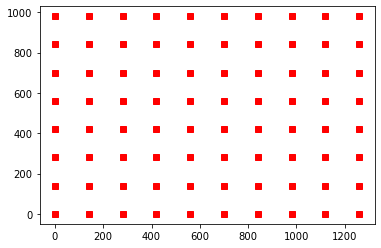

In [4]:
# Non-distorted pixels
ptosn = np.ones((8*10,3), np.float32) 
ptosn[:,:2] = np.mgrid[0:10, 0:8].T.reshape(-1,2) * (700*2/10)
#print(objp)
plt.plot(ptosn[:,0],ptosn[:,1], 'rs')

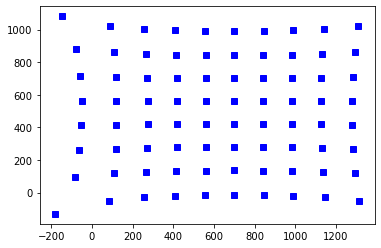

In [5]:
# Distorted pixels
cam1 = Cam1()
ptosd = np.zeros((8*10,3), np.float32)
for i, pn in enumerate(ptosn):
    ptosd[i,0:2]= cam1.distort(pn)
plt.plot(ptosd[:,0],ptosd[:,1], 'bs')

Error medio por pixel: 0.11180340051651001  -> Error máximo: 1.0


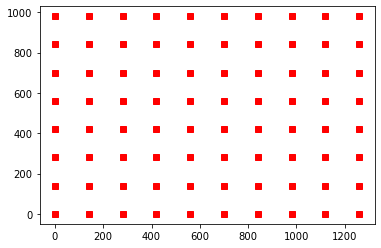

In [6]:
# Corrected pixels (non-distorted)
ptosn_ = np.zeros((8*10,3), np.float32)
for i, pd in enumerate(ptosd):
    ptosn_[i,0:2]= cam1.undistort(pd)
plt.plot(ptosn_[:,0],ptosn_[:,1], 'rs')

print("Error medio por pixel:", np.linalg.norm(ptosn-ptosn_)/80," -> Error máximo:",np.max(ptosn-ptosn_))

# Camera model
The camera model, called the projection matrix $^{d}\mathbf{P}_w = \, ^{d}\mathbf{T}_w$, is composed of the following transformations:

$^{d}\mathbf{P}_w = \, ^{d}\mathbf{T}_p \cdot \, ^{p}\mathbf{T}_c \cdot \, ^{c}\mathbf{ T}_w $$

$$^{d}\mathbf{P}_w = \lambda \cdot \begin{bmatrix} {f}_u & 0 & {u}_0 \\ 0 & {f}_v & {v}_0 \\ 0 & 0 & 1 \end{bmatrix} \cdot \, \begin{bmatrix} 1&0&0&0 \\ 0&1&0&0 \\ 0&0&1&0 \end{bmatrix} \cdot \, \begin{bmatrix} {r}_{11}&{r}_ {12}&{r}_{13}&{t}_x \\ {r}_{21}&{r}_{22}&{r}_{23}&{t}_y \\ {r }_{31}&{r}_{32}&{r}_{33}&{t}_z \\ 0&0&0&1 \end{bmatrix}$$

Be careful! In this case, the meaning of the subscript $d$ refers to discrete and not distorted pixel. That is, $d$ refers to the coordinate system of the undistorted pixels in the discrete image plane. So here $d$ equals $nd$.

In [7]:
"""Camera class definition"""
class Cam2:
    
    """Intrinsec parameters"""
    fu = 1580  # fu = f/dx
    fv = 1580  # fv = f/dy
    uo = 350  # uo = xo
    vo = 300  # vo = yo

    """Extrinsec parameters"""
    radius = 1000
    angle = 180 - 45

    rX = (pi / 180) * (angle)  # Rotation angle on axis X
    rY = 0  # Rotation angle on axis Y
    rZ = 0  # Rotation angle on axis Z
    tX = 0  # Traslation on axis X
    tY = math.sin((pi / 180) * (angle)) * radius  # Traslation on axis Y
    tZ = -math.cos((pi / 180) * (angle)) * radius  # Traslation on axis Z

    """Construction of the projection matrix"""
    K = np.array([[fu, 0, uo], [0, fv, vo], [0, 0, 1]])
    K1 = np.array([[fu, 0, uo, 0], [0, fv, vo, 0], [0, 0, 1, 0]])
    Rx = np.array([[1, 0, 0], [0, math.cos(rX), -math.sin(rX)],
                   [0, math.sin(rX), math.cos(rX)]])  # Rotation matrix on axis X
    Ry = np.array([[math.cos(rY), 0, math.sin(rY)], [0, 1, 0],
                   [-math.sin(rY), 0, math.cos(rY)]])  # Rotation matrix on axis  Y
    Rz = np.array([[math.cos(rZ), -math.sin(rZ), 0], [math.sin(rZ), math.cos(rZ), 0],
                   [0, 0, 1]])  # Rotation matrix on axis Z
    R = np.dot(np.dot(Rx, Ry), Rz)  # Rotation matrix of the camera with respect to the world
    T = np.array([[tX], [tY], [tZ]])  # Traslation marix of the camera  with respect to the world

    """Projection matrix"""
    P = np.dot(K1, np.linalg.inv(np.concatenate((np.concatenate((R, T), axis=1), np.array([[0, 0, 0, 1]])))))
    P=P/P[2][3]
    print('Projection matrix:\n',P)
    
    #def __init__
    
    # Returns the projections of the wordl points X as pixels U 
    def project(self,X):
        U = np.dot(self.P, X)
        U = np.concatenate([[U[0] / U[2]], [U[1] / U[2]], [np.ones(U[0].shape)]])
        return(U)
    
    # Shows the image
    def im_show(self, U):
        nPuntos = len(U[0])
        nPuntos_mitad = int(nPuntos/2)
        fig = plt.figure(figsize=(8,6))
        plt.plot(U[0][:nPuntos_mitad], U[1][:nPuntos_mitad], marker='s', ls='');
        plt.plot(U[0][nPuntos_mitad:], U[1][nPuntos_mitad:], marker='^', ls='');
        

Projection matrix:
 [[ 1.58000000e+00 -2.47487373e-01 -2.47487373e-01  3.50000000e+02]
 [ 0.00000000e+00 -1.32936075e+00  9.05096680e-01  3.00000000e+02]
 [ 0.00000000e+00 -7.07106781e-04 -7.07106781e-04  1.00000000e+00]]


In [8]:
# Wordl points
nPuntos = 150
amplitudX = 500
amplitudY = 500
amplitudZ = 500

nPuntos_mitad = int(nPuntos/2)
nPuntos_resto = int(nPuntos - nPuntos_mitad)

x = (np.random.rand(1, nPuntos) - 0.5) * amplitudX
y = np.concatenate( ( np.random.rand(1, nPuntos_mitad) * amplitudY, np.zeros((1, nPuntos_resto)) ), axis=1 )
z = np.concatenate( ( np.zeros((1, nPuntos_mitad)), np.random.rand(1, nPuntos_resto) * amplitudZ ), axis=1 )
X =  np.concatenate( (x,y,z,np.ones((1,nPuntos))), axis=0)

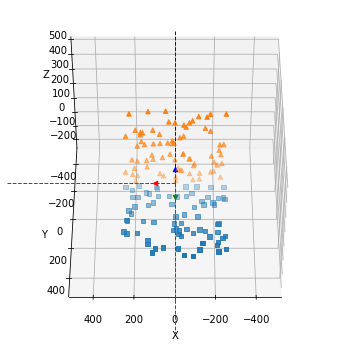

In [9]:
# Shows the scenario
for ii in range(40,95,10):

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[0][:nPuntos_mitad], X[1][:nPuntos_mitad], X[2][:nPuntos_mitad], marker='s')
    ax.scatter(X[0][nPuntos_mitad:], X[1][nPuntos_mitad:], X[2][nPuntos_mitad:], marker='^')

    # Se define el tamaño del escenario
    ax.set_xlim3d(-500,500)
    ax.set_ylim3d(-500,500)
    ax.set_zlim3d(-250,500)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Dibujar el sistema de coordenadas
    ax.plot([0,1000],[0,0],[0,0],'r', linestyle='dashed', linewidth=1)
    ax.scatter([100], [0], [0], color = 'r', marker='<')
    ax.plot([0,0],[0,1000],[0,0],'g', linestyle='dashed', linewidth=1)
    ax.scatter([0], [100], [0], color = 'g', marker='v')
    ax.plot([0,0],[0,0],[0,1000],'b', linestyle='dashed', linewidth=1)
    ax.scatter([0], [0], [100], color = 'b', marker='^')

    ax.view_init(elev=45, azim=ii)
    plt.show()

    time.sleep(1/2)
    if ii < 90:
        clear_output()

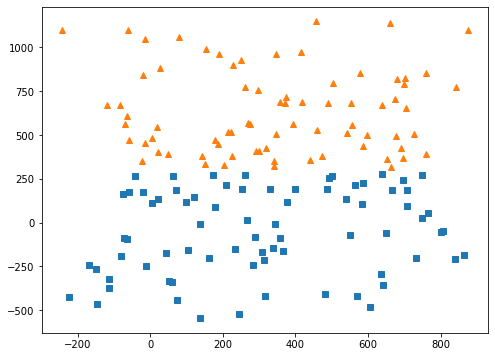

In [10]:
# Projected pixels
cam2 = Cam2()
U=cam2.project(X)
cam2.im_show(U)